# Credit Card Fraud Detection 

## Introduction:
* With the provided information, build a model to predict whether this customer will commit fraud when using a credit card or not?
* It is important for credit card issuers to detect customers who commit credit card fraud so that when they buy products and services, they will not be charged for those products and services.
* This dataset contains transaction information with 492 TH frauds out of a total of 284,807 transactions. This is a severely imbalanced dataset with the positive class (fraud) accounting for 0.172% of all transactions. Therefore, we should not use metrics `Accuracy` to evaluate the model because the number of zero labels is too much, instead, we should focus on F1 Score, Precision/Recall, ROC_AUC or Confusion matrix to have more accurate assessment of the performance of the models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model, metrics
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

##Load Data

In [2]:
df=pd.read_csv('creditcard.csv')
# Converting all column names to lower case
df.columns = df.columns.str.lower()
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* Due to security issues, the original features V1, V2, ... V28 have been modified by PCA. However, we can guess that these features could be credit card number, expiration date, CVV, cardholder name, transaction location, transaction date-time, etc.
* The only two features that have not been converted with PCA are `Time` and `Amount`. Therefore, we only need to focus on processing these two features

##Exploratory Data Analysis

In [3]:
df.shape

(284807, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [5]:
df.isnull().sum().sum()

0

This dataset has 29 `float` variables, 1 target variable is `int` and no missing values

In [6]:
df['class'].value_counts()/len(df)

class
0    0.998273
1    0.001727
Name: count, dtype: float64

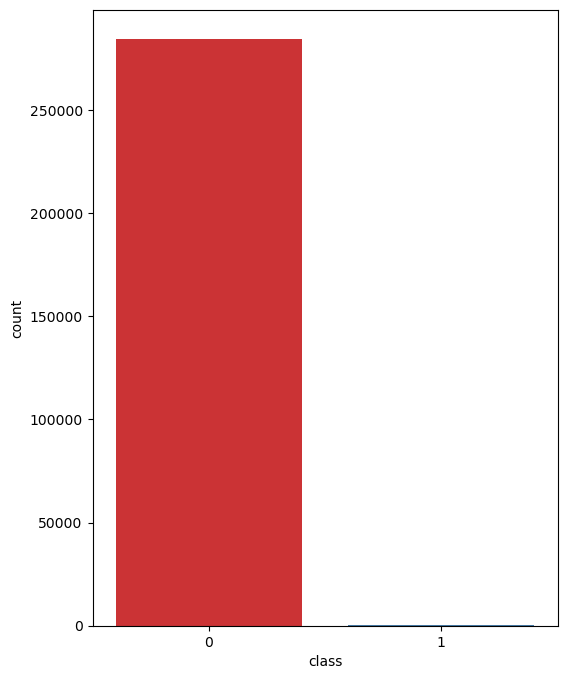

In [7]:
f,ax = plt.subplots(figsize=(6,8))
ax = sns.countplot(x='class', data=df, palette='Set1')
plt.show()

* This dataset contains transaction information with 492 TH frauds out of a total of 284,807 transactions. This is a severely imbalanced dataset with the positive class (fraud) accounting for 0.172% of all transactions

In [8]:
df[['time','amount']].describe()

,time,amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


**Observations:**
* On average, each transaction happens every 94813s
* The TB transaction amount is 88.34 with a standard deviation of 250, the maximum transaction amount is 25691
* Based on mean and max, it is easy to see that these two variables have outliers

In [9]:
fraud = df[df['class']==1]
normal = df[df['class']==0]
print(f'Shape of Fraud Transactions: {fraud.shape}')
print(f'Shape of Normal Transactions: {normal.shape}')

Shape of Fraud Transactions: (492, 31)
Shape of Normal Transactions: (284315, 31)


In [10]:
pd.concat([fraud['amount'].describe(), normal['amount'].describe()], axis=1)

,amount,amount
count,492.000000,284315.000000
mean,122.211321,88.291022
std,256.683288,250.105092
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,2125.870000,25691.160000


In [11]:
fraud['amount'].value_counts().head()

amount
1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: count, dtype: int64

**Observations:**
* With fraud transactions, the average amount of fraud is 122.22 USD, the highest is 2125 USD, the lowest is 0 and the maximum amount is 1 USD with 113 times.


###Distribution of Time

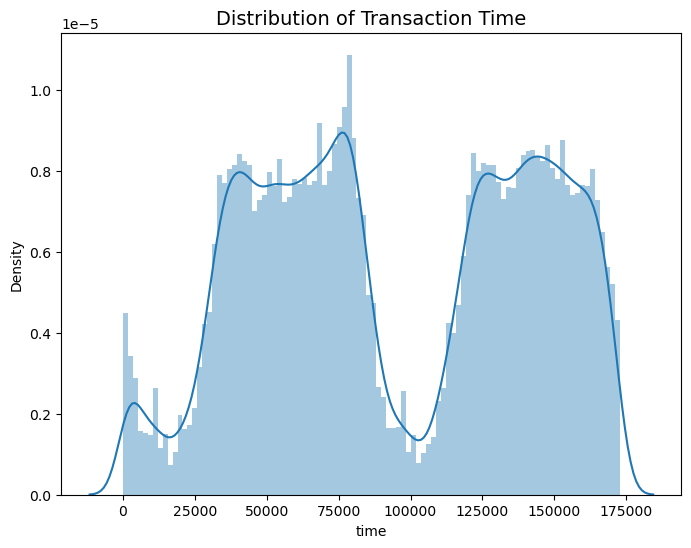

In [12]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Transaction Time', fontsize=14)
sns.distplot(df['time'], bins=100)
plt.show()

**Observations:**
* This data set contains two-day trading information, looking at the distribution chart we see two peaks and two troughs. Most likely, the two peaks are transactions during the day because of the high volume of transactions, and the two bottoms are transactions at night when everyone is asleep.

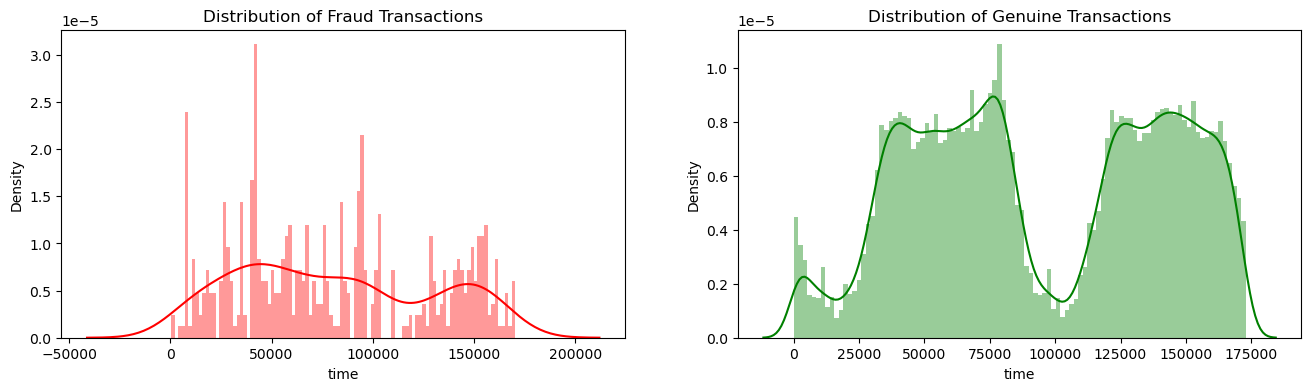

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(fraud['time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(normal['time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

###Distribution of Amount

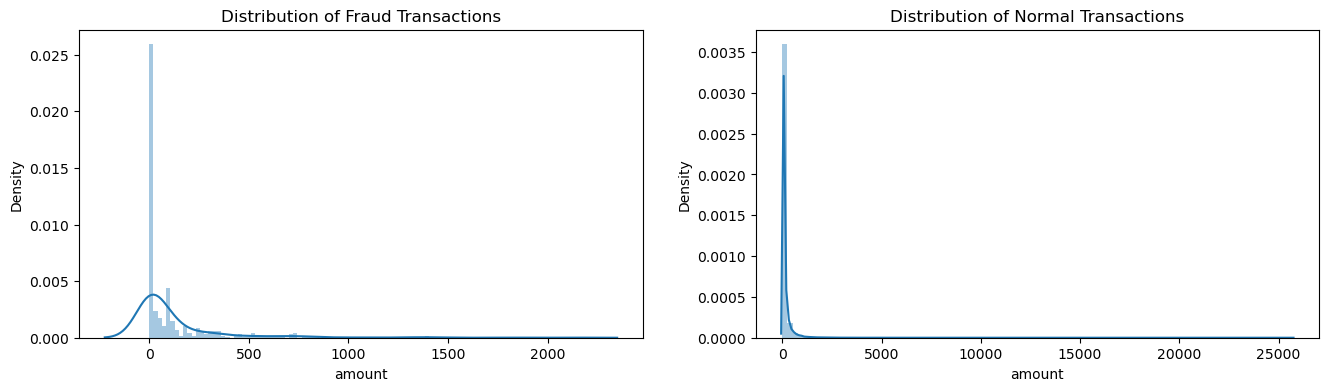

In [14]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.distplot(fraud['amount'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(normal['amount'], bins=100, ax=axs[1])
axs[1].set_title("Distribution of Normal Transactions")

plt.show()

In [15]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
# Scale amount by log
df['amount_log'] = np.log(df.amount + 0.0001)

Log transforms are useful when applied to skewed distributions because they tend to expand values in the lower magnitude range and tend to compress or reduce values in the magnitude range. higher

##Spliting the data

In [17]:
X = df.drop(['class','time'], axis=1)

y = df['class']

In [18]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

##Scaling the data

In [19]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

##SMOTE

In [20]:
from collections import Counter
from imblearn.over_sampling import SMOTE
print('Original dataset shape %s' % Counter(y_train))

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train_smt))

Original dataset shape Counter({0: 227454, 1: 391})
Resampled dataset shape Counter({0: 227454, 1: 227454})


##Modeling

In [21]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    #print("Precision  = {}".format(precision))
    #print("Recall  = {}".format(recall))
    print("F1 Score  = {}".format(f1))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    
    return model, accuracy, roc_auc, f1, coh_kap, time_taken

### LightGBM

[LightGBM] [Info] Number of positive: 391, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001716 -> initscore=-6.365996
[LightGBM] [Info] Start training from score -6.365996
Accuracy = 0.997454443313086
ROC Area under Curve = 0.8455322089075653
F1 Score  = 0.49122807017543857
Cohen's Kappa = 0.49006056799894204
Time taken = 4.349714279174805
              precision    recall  f1-score   support

           0    0.99945   0.99800   0.99872     56861
           1    0.38043   0.69307   0.49123       101

    accuracy                        0.99745     56962
   macro avg    0.68994   0.84553   0.74498     56962
weighted avg    0.99836   0.99745   0.99782     56962



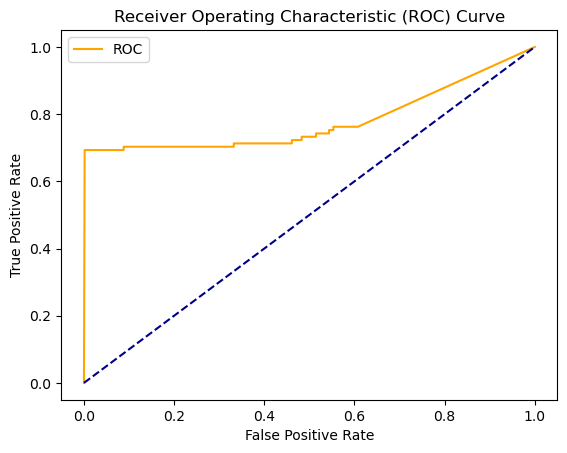

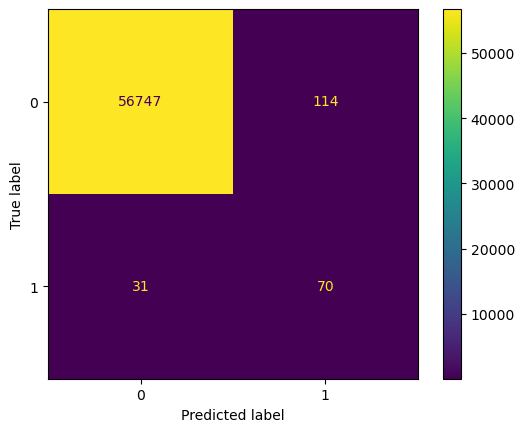

In [23]:

import lightgbm as lgb

model_lgbsmt = lgb.LGBMClassifier()
model_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, f1_score_lgbsmt,coh_kap_lgbsmt, tt_lgbsmt = run_model(model_lgbsmt, X_train, y_train, X_test, y_test)

### LightGBM with SMOTE

[LightGBM] [Info] Number of positive: 227454, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy = 0.9987886661282961
ROC Area under Curve = 0.9252677320984767
F1 Score  = 0.7136929460580913
Cohen's Kappa = 0.7131019225286181
Time taken = 10.770734071731567
              precision    recall  f1-score   support

           0    0.99974   0.99905   0.99939     56861
           1    0.61429   0.85149   0.71369       101

    accuracy                        0.99879     56962
   macro avg    0.80701   0.92527   0.85654     56962
weighted avg    0.99905   0.99879   0.99889     56962



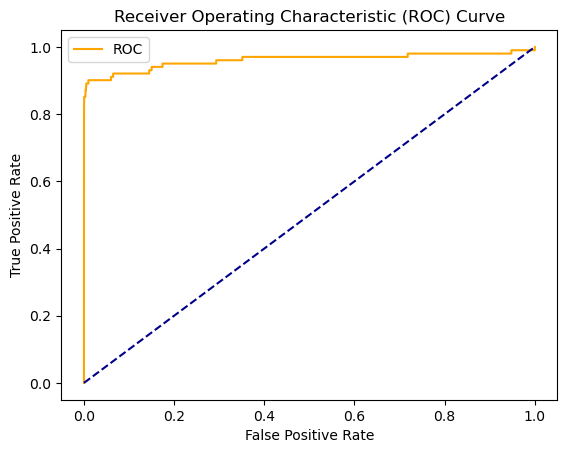

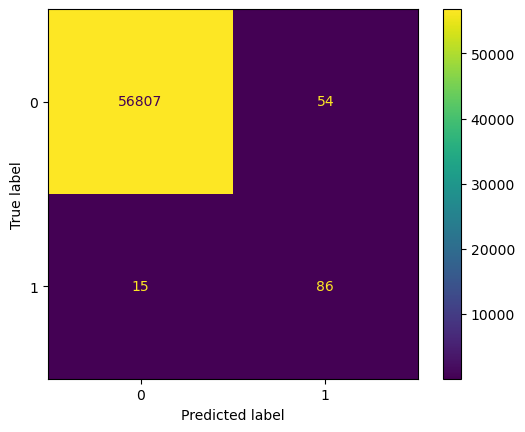

In [24]:

import lightgbm as lgb

model_lgbsmt = lgb.LGBMClassifier()
model_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, f1_score_lgbsmt,coh_kap_lgbsmt, tt_lgbsmt = run_model(model_lgbsmt, X_train_smt, y_train_smt, X_test, y_test)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

### KNeighbor Classifier

Accuracy = 0.9995611109160493
ROC Area under Curve = 0.8960044304671406
F1 Score  = 0.8648648648648649
Cohen's Kappa = 0.8646469224129033
Time taken = 60.43069386482239
              precision    recall  f1-score   support

           0    0.99963   0.99993   0.99978     56861
           1    0.95238   0.79208   0.86486       101

    accuracy                        0.99956     56962
   macro avg    0.97601   0.89600   0.93232     56962
weighted avg    0.99955   0.99956   0.99954     56962



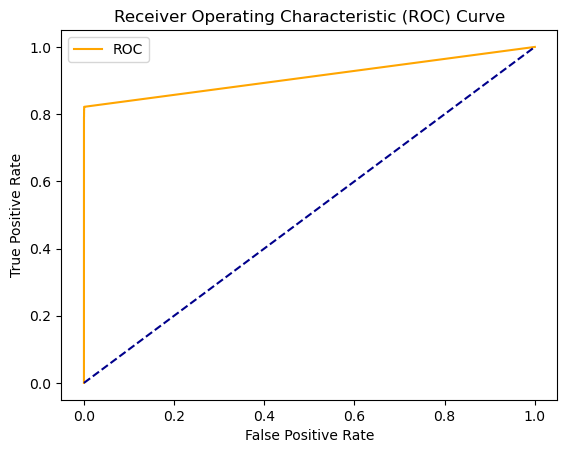

In [ ]:
knn_clf, accuracy_knn, roc_auc_knn, f1_score_knn,coh_kap_knn, tt_knn = run_model(knn_clf, X_train, y_train, X_test, y_test)

### KNeighbor Classifier with SMOTE

In [ ]:
knn_clf, accuracy_knn, roc_auc_knn, f1_score_knn,coh_kap_knn, tt_knn = run_model(knn_clf, X_train_smt, y_train_smt, X_test, y_test)

### Tham số tà đạo 

In [ ]:
model_lgbsmt = lgb.LGBMClassifier(num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, f1_score_lgbsmt,coh_kap_lgbsmt, tt_lgbsmt = run_model(model_lgbsmt, X_train, y_train, X_test, y_test)

### Tham số tà đạo with SMOTE

In [ ]:
model_lgbsmt = lgb.LGBMClassifier(num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, f1_score_lgbsmt,coh_kap_lgbsmt, tt_lgbsmt = run_model(model_lgbsmt, X_train_smt, y_train_smt, X_test, y_test)

##Fine Tuning

In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna  # pip install optuna
import lightgbm as lgb
#import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def objective(trial, X_train_smt, y_train_smt):
    max_depth=trial.suggest_int('max_depth',2,14)
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        #"n_estimators": trial.suggest_categorical("n_estimators", 1,300 ),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 4, 2**max_depth),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 500),
        "max_bin": trial.suggest_int("max_bin", 10, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
    }
    #scoring = {'accuracy' : make_scorer(accuracy_score), 
    #      'precision' : make_scorer(precision_score),
    #     'recall' : make_scorer(recall_score), 
    #    'f1_score' : make_scorer(f1_score)}

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMClassifier(**param_grid)
    model.fit(X_train_smt,y_train_smt)
    scores = cross_val_score(model, X_train_smt, y_train_smt,
                             scoring=make_scorer(f1_score, average='weighted', labels=[1]),cv=cv, n_jobs=-1)
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
func = lambda trial: objective(trial, X_train_smt, y_train_smt)
study.optimize(func, n_trials=100)


#study = optuna.create_study(direction='maximize')
#func = lambda trial: objective(trial, X_train_smt, y_train_smt)
#study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (Accuracy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
param_lgb = {'max_depth': 13,
		'learning_rate': 0.17554166946002825,
		'num_leaves': 5433,
		'min_data_in_leaf': 459,
		'max_bin': 139,
		'lambda_l1': 0,
		'lambda_l2': 90,
		'min_gain_to_split': 12.191244592244884,
		'bagging_fraction': 0.4,
		'bagging_freq': 1,
		'feature_fraction':  0.30000000000000004    
}

lgb_opt = lgb.LGBMClassifier(**param_lgb)
run_model(lgb_opt, X_train_smt, y_train_smt, X_test, y_test)

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='colab'

def model_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]

    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2,
                        text = conf_matrix,
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data   = pd.DataFrame(list(df))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>' + 'LightGBM after tuning',
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    fig.show("colab")
    # pio.write_image(fig, "op.png")

In [ ]:
model_performance(lgb_opt, X_test, y_test)

**Observation:**
* The model has improved significantly with the `f1_score` index increased from 65.3% to 81.3%
* With the Credit Card Fraud Detection problem, we should focus on reducing the number of Type I (FP) errors that the model predicts. Customers fall into the category I error about the fact that they committed fraud, but the model predicts that these customers do not commit fraud. This leads to a great loss for credit institutions when we have wrongly predicted these customers.
* Therefore, in addition to choosing a good model, we also need to choose the models with the lowest error types of type I.

=> The `LightGBM` model will be the chosen model to solve this problem!